In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from datetime import datetime
from pathlib import Path

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\jespe\Documents\GitHub_local\ARFusion


## Functions

### Processing and formatting CV results 

In [2]:
def get_average_and_std_df(results_dict, with_metric_as_index=False):
    losses = results_dict['losses']
    accs = results_dict['accs']
    iso_accs = results_dict['iso_accs']
    sensitivities = results_dict['sensitivities']
    specificities = results_dict['specificities']
    f1_scores = results_dict['F1_scores']
    
    losses_avg = np.mean(losses)
    losses_std = np.std(losses)
    accs_avg = np.mean(accs)
    accs_std = np.std(accs)
    iso_accs_avg = np.mean(iso_accs)
    iso_accs_std = np.std(iso_accs)
    sens_avg = np.mean(sensitivities)
    sens_std = np.std(sensitivities)
    spec_avg = np.mean(specificities)
    spec_std = np.std(specificities)
    f1_avg = np.mean(f1_scores)
    f1_std = np.std(f1_scores)
    
    df_CV = pd.DataFrame(data={
        "metric": ["Loss", 'Accuracy', 'Isolate accuracy', 'Sensitivity', 'Specificity', 'F1'], 
        "avg": [losses_avg, accs_avg, iso_accs_avg, sens_avg, spec_avg, f1_avg], 
        "std": [losses_std, accs_std, iso_accs_std, sens_std, spec_std, f1_std]
    })
    if with_metric_as_index:
        df_CV.set_index("metric", inplace=True)
    return df_CV


def get_ab_stats_df(results_dict, with_ab_as_index=False):
    ab_stats_list = results_dict['ab_stats']
    
    data_dict = {}
    antibiotics = ab_stats_list[0]['antibiotic'].tolist()
    data_dict.update({"antibiotic": antibiotics})
    for ab_stats in ab_stats_list:
        ab_stats['S_share'] = ab_stats['num_S'] / ab_stats['num_tot']
        ab_stats['R_share'] = ab_stats['num_R'] / ab_stats['num_tot']

    num_tot = np.array([ab_stats['num_tot'].tolist() for ab_stats in ab_stats_list])
    avg_num = np.mean(num_tot, axis=0).astype(int).tolist()
    std_num = np.std(num_tot, axis=0).tolist()
    s_shares = np.array([ab_stats['S_share'].tolist() for ab_stats in ab_stats_list])
    r_shares = np.array([ab_stats['R_share'].tolist() for ab_stats in ab_stats_list])
    s_share_median = np.median(s_shares, axis=0).tolist()
    s_share_std = np.std(s_shares, axis=0).tolist()
    r_share_median = np.median(r_shares, axis=0).tolist()
    r_share_std = np.std(r_shares, axis=0).tolist()
    data_dict.update({
        "avg_num": avg_num, "std_num":std_num,
        "S_share_median": s_share_median, "R_share_median": r_share_median,
        "S_share_std":s_share_std, "R_share_std": r_share_std
    })
    
    metrics = ['accuracy', 'sensitivity', 'specificity', "precision", 'F1']
    for metric in metrics:
        arr = np.array([ab_stats[metric] for ab_stats in ab_stats_list])
        avg = np.nanmean(arr, axis=0)
        std = np.nanstd(arr, axis=0)
        # if np.isnan(arr).any():
        #     print("metric:", metric)
        #     print(arr)
        #     print("avg:", avg)
        #     print("std:", std)
        data_dict.update({metric+"_avg": avg.tolist(), metric+"_std": std.tolist()})

    df_ab_CV = pd.DataFrame(data=data_dict)
    if with_ab_as_index:
        df_ab_CV.set_index("antibiotic", inplace=True)
    return df_ab_CV

### TEMPORARY FIX - make sure no GPU tensors are saved in the results
import pickle, io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


### Plotting functions

In [3]:
def plot_metric_by_ab(
    df_CV_ab,
    metric,
    use_std = True,
    sort_by_desc_metric = True,
    legend_labels = None,
    legend_loc = None,
    colors = ['slategray', 'tab:green', 'gold', 'tab:red'],
    title = None, 
    figsize = (12, 8), 
    save_path = None
):
    _, ax = plt.subplots(figsize=figsize)
    if sort_by_desc_metric:
        df_CV_ab = df_CV_ab.sort_values(by=(metric+'_avg', 'No PT'), ascending=False)
    if use_std:
        df_CV_ab.plot(kind='bar', y=metric+'_avg', yerr=metric+'_std', rot=0, figsize=(13, 8), capsize=2, ecolor='k', color=colors, ax=ax)
    else:
        df_CV_ab.plot(kind='bar', y=metric+'_avg', rot=0, figsize=(13, 8), color=colors, ax=ax)
    if title:
        if title == 'none':
            pass
        else:
            ax.set_title(title) 
    else:
        ax.set_title(f'{metric} by antibiotic')
    ax.set_xlabel('Antibiotic')
    ax.set_ylabel(metric)
    model_names = df_CV_ab[metric+'_avg'].columns.tolist()
    ax.legend(legend_labels if legend_labels else model_names, loc=legend_loc)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


def plot_metric_by_ab_with_distr(
    df_CV_ab,
    metric,
    use_std = True,
    sort_by_desc_S_share = True,
    show_distr_std = False,
    legend_labels = None,
    legend_loc = None,
    colors = ['slategray', 'tab:green', 'gold', 'tab:red'],
    title = None, 
    figsize = (12, 8), 
    save_path = None
):
    model_names = df_CV_ab[metric+'_avg'].columns.tolist()
    _, ax = plt.subplots(figsize=(13, 8))
    if sort_by_desc_S_share:
        df_CV_ab = df_CV_ab.sort_values(by='S_share_median', ascending=False)
    ind = np.arange(len(df_CV_ab.index))
    width = 0.15
    if use_std:
        for i, model in enumerate(model_names):
            ax.bar(
                ind + (i-1)*width, df_CV_ab[metric+'_avg'][model], width, yerr=df_CV_ab[metric+'_std'][model], 
                label=model, color=colors[i], capsize=2, ecolor='k'
            )
    else:
        for i, model in enumerate(model_names):
            ax.bar(ind + (i-1)*width, df_CV_ab[metric+'_avg'][model], width, label=model, color=colors[i])
    if show_distr_std:
        ax.bar(ind + 3*width, df_CV_ab['S_share_median'], width, color='darkgreen', label='S share', yerr=df_CV_ab['S_share_std'], capsize=2, ecolor='k')
        ax.bar(ind + 3*width, df_CV_ab['R_share_median'], width, bottom=df_CV_ab['S_share_median'], color='darkred', label='R share', yerr=df_CV_ab['R_share_std'], capsize=2, ecolor='k')
    else:
        ax.bar(ind + 3*width, df_CV_ab['R_share_median'], width, bottom=df_CV_ab['S_share_median'], color='darkred', label='R share')
        ax.bar(ind + 3*width, df_CV_ab['S_share_median'], width, color='darkgreen', label='S share')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(df_CV_ab.index)
    if title:
        if title == 'none':
            pass
        else:
            ax.set_title(title) 
    else:
        ax.set_title(f'{metric} by antibiotic')
    ax.set_xlabel('Antibiotic')
    ax.set_ylabel(metric)
    ax.legend(legend_labels if legend_labels else model_names, loc=legend_loc)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

## Compare effect of masking method on antibiotic distributions

In [4]:
results_random = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'))
results_class = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'))

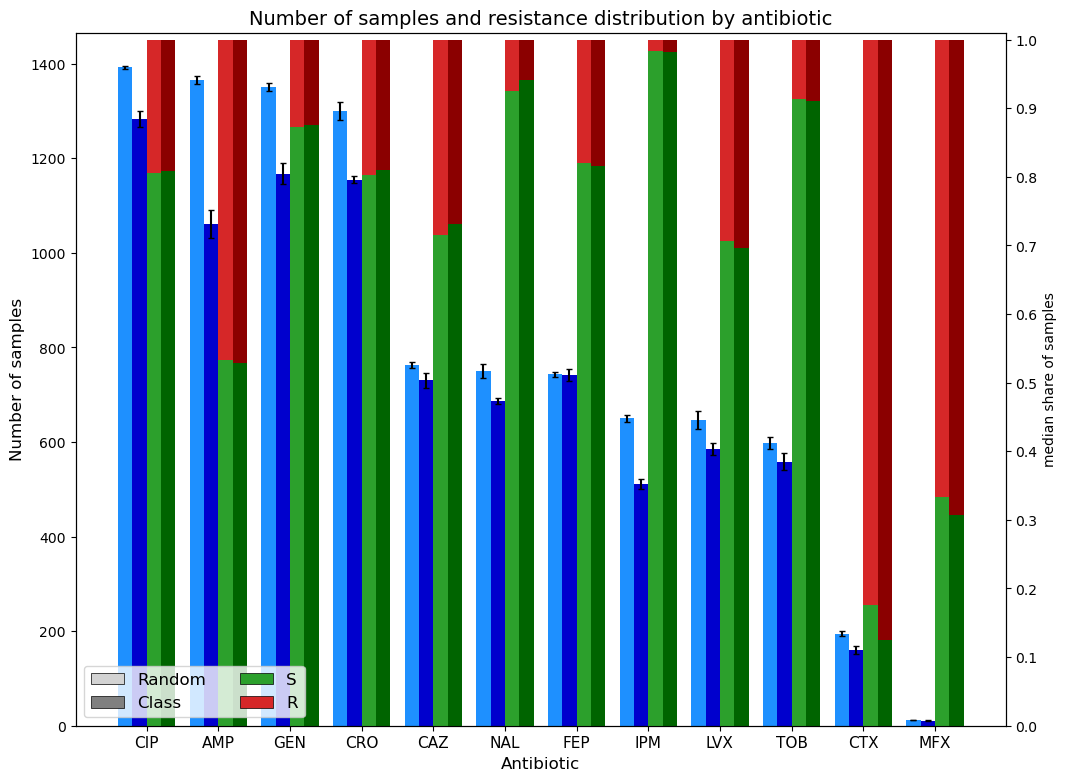

In [5]:
df_ab_random = get_ab_stats_df(results_random, with_ab_as_index=True)
df_ab_class = get_ab_stats_df(results_class, with_ab_as_index=True)

fig, ax = plt.subplots(figsize=(12, 9))
bar_width = 0.2
df_ab_random = df_ab_random.sort_values(by='avg_num', ascending=False)
df_ab_class = df_ab_class.reindex_like(df_ab_random)
ind = np.arange(len(df_ab_random.index))
bar_num = ax.bar(
    ind-3/2*bar_width, df_ab_random['avg_num'], width=bar_width, color='dodgerblue',
    yerr=df_ab_random['std_num'], capsize=2, ecolor='k'
)
bar_num_class = ax.bar(
    ind-bar_width/2, df_ab_class['avg_num'], width=bar_width, color='mediumblue',
    yerr=df_ab_class['std_num'], capsize=2, ecolor='k'
)
ax2 = ax.twinx()
bar_R_share = ax2.bar(
    ind+bar_width/2, df_ab_random['R_share_median'], bottom=df_ab_random['S_share_median'], width=bar_width, color='tab:red'
)
bar_S_share = ax2.bar(
    ind+bar_width/2, df_ab_random['S_share_median'], width=bar_width, color='tab:green'
)
bar_R_share_class = ax2.bar(
    ind+3/2*bar_width, df_ab_class['R_share_median'], bottom=df_ab_class['S_share_median'], width=bar_width, color='darkred'
)
bar_S_share_class = ax2.bar(
    ind+3/2*bar_width, df_ab_class['S_share_median'], width=bar_width, color='darkgreen'
)
ax.set_xticks(ind, df_ab_random.index, fontsize=11)
ax.set_title('Number of samples and resistance distribution by antibiotic', fontsize=14)
ax.set_xlabel('Antibiotic', fontsize=12)
ax.set_ylabel('Number of samples', fontsize=12)
ax2.set_ylabel('median share of samples')
ax2.set_ylim(0, 1.01)
ax2.set_yticks(np.arange(0, 1.01, 0.1))

# custom legend
from matplotlib.patches import Rectangle

num_rand = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
num_class = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
S_share = Rectangle((0,0),1,1,fc='tab:green', edgecolor='k', linewidth=0.5)
R_share = Rectangle((0,0),1,1,fc='tab:red', edgecolor='k', linewidth=0.5)

ax2.legend(
    handles=[num_rand, num_class, S_share, R_share], 
    labels=['Random', 'Class', 'S', 'R'],
    loc='lower left',
    fontsize=12, 
    ncols=2
)
plt.show()

# Compare effect of pre-training difficulty and masking method

## PT: Random masking | FT: Random masking

In [6]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_noPT = torch.load(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'), map_location=torch.device('cpu'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_0.9', 'CV_results.pkl'))
model_names = ['No PT', 'Easy PT', 'Medium PT', 'Hard PT']
colors = ['slategray', 'tab:green', 'gold', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [7]:
drop_metrics = ['Loss', 'Isolate accuracy', 'Accuracy']

In [8]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                     std            \
model                No PT   Easy PT Medium PT   Hard PT     No PT   Easy PT   
metric                                                                         
Accuracy          0.946814  0.946991  0.948449  0.948900  0.004637  0.003676   
F1                0.874695  0.875465  0.878521  0.879817  0.009961  0.007237   
Isolate accuracy  0.946814  0.946991  0.948449  0.948900  0.004637  0.003676   
Loss              0.149597  0.149192  0.146501  0.148372  0.008172  0.008240   
Sensitivity       0.836947  0.839979  0.840416  0.843100  0.012828  0.011381   
Specificity       0.978131  0.977496  0.979238  0.979059  0.002428  0.002831   

                                      
model            Medium PT   Hard PT  
metric                                
Accuracy          0.003893  0.003910  
F1                0.008106  0.007803  
Isolate accuracy  0.003893  0.003910  
Loss              0.009087  0.011312  
Sensitivity       0.010033  0.007992  
Specificity       0.002486  0.002961

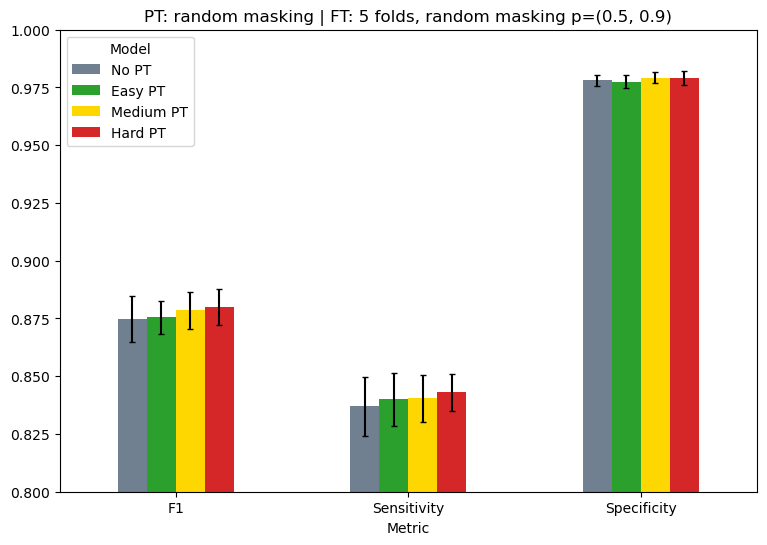

In [9]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: random masking | FT: 5 folds, random masking p=(0.5, 0.9)')
plt.show()

### Antibiotic level

In [10]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp
df_CV_ab

avg_num    std_num S_share_median R_share_median S_share_std  \
model                                                                     
antibiotic                                                                
AMP         1365.0   9.002222       0.532943       0.467057    0.007435   
CAZ          763.0   5.635601       0.714472       0.285528    0.007592   
CIP         1392.0   3.600000       0.806196       0.193804    0.003432   
CRO         1300.0  18.271289       0.802870       0.197130    0.008048   
CTX          195.0   5.306600       0.176166       0.823834    0.020343   
FEP          743.0   5.678028       0.819892       0.180108    0.010507   
GEN         1350.0   8.867920       0.873074       0.126926    0.003746   
IPM          650.0   7.761443       0.983025       0.016975    0.003239   
LVX          647.0  19.487432       0.706408       0.293592    0.009065   
MFX           12.0   0.800000       0.333333       0.666667    0.100632   
NAL          750.0  15.370101       0.924603       0.075397    0.006146   
TOB          598.0  12.457929       0.913043       0.086957    0.007915   

           R_share_std accuracy_avg                                ...  \
model                         No PT   Easy PT Medium PT   Hard PT  ...   
antibiotic                                                         ...   
AMP           0.007435     0.890196  0.890790  0.890200  0.891085  ...   
CAZ           0.007592     0.929048  0.926129  0.927454  0.931897  ...   
CIP           0.003432     0.957469  0.958488  0.960782  0.961210  ...   
CRO           0.008048     0.964611  0.964173  0.965384  0.965697  ...   
CTX           0.020343     0.949654  0.947936  0.957950  0.953573  ...   
FEP           0.010507     0.930824  0.931091  0.932203  0.935424  ...   
GEN           0.003746     0.947271  0.945941  0.949486  0.948002  ...   
IPM           0.003239     0.987691  0.989531  0.989231  0.989234  ...   
LVX           0.009065     0.961143  0.961734  0.962329  0.961392  ...   
MFX           0.100632     0.810023  0.840793  0.858974  0.810023  ...   
NAL           0.006146     0.969163  0.969127  0.970451  0.971060  ...   
TOB           0.007915     0.968157  0.972164  0.972519  0.972524  ...   

           precision_std              F1_avg                                \
model          Medium PT   Hard PT     No PT   Easy PT Medium PT   Hard PT   
antibiotic                                                                   
AMP             0.009398  0.014566  0.874755  0.875437  0.874398  0.875606   
CAZ             0.012446  0.003980  0.874644  0.868215  0.868901  0.877865   
CIP             0.008713  0.015885  0.884607  0.889539  0.895163  0.896822   
CRO             0.015544  0.011623  0.905630  0.903967  0.906748  0.907631   
CTX             0.009375  0.011276  0.969796  0.968698  0.974751  0.972021   
FEP             0.041241  0.040035  0.807030  0.809129  0.810536  0.821369   
GEN             0.025789  0.028985  0.772851  0.766297  0.786715  0.778197   
IPM             0.165831  0.081991  0.571707  0.652383  0.628687  0.622062   
LVX             0.013376  0.016034  0.932531  0.934503  0.935134  0.934073   
MFX             0.089883  0.099126  0.839052  0.877148  0.889850  0.839052   
NAL             0.052202  0.073047  0.752318  0.757549  0.758108  0.767031   
TOB             0.019414  0.043410  0.812328  0.836995  0.837983  0.840431   

              F1_std                                
model          No PT   Easy PT Medium PT   Hard PT  
antibiotic                                          
AMP         0.017749  0.017068  0.017739  0.017203  
CAZ         0.023960  0.016729  0.020902  0.011765  
CIP         0.012524  0.009866  0.011285  0.008548  
CRO         0.017020  0.009021  0.012584  0.012907  
CTX         0.006350  0.006830  0.001708  0.007144  
FEP         0.030353  0.026482  0.024496  0.027878  
GEN         0.037402  0.040223  0.025091  0.030707  
IPM         0.084273  0.102445  0.106012  0.083328  
LVX         0.003813

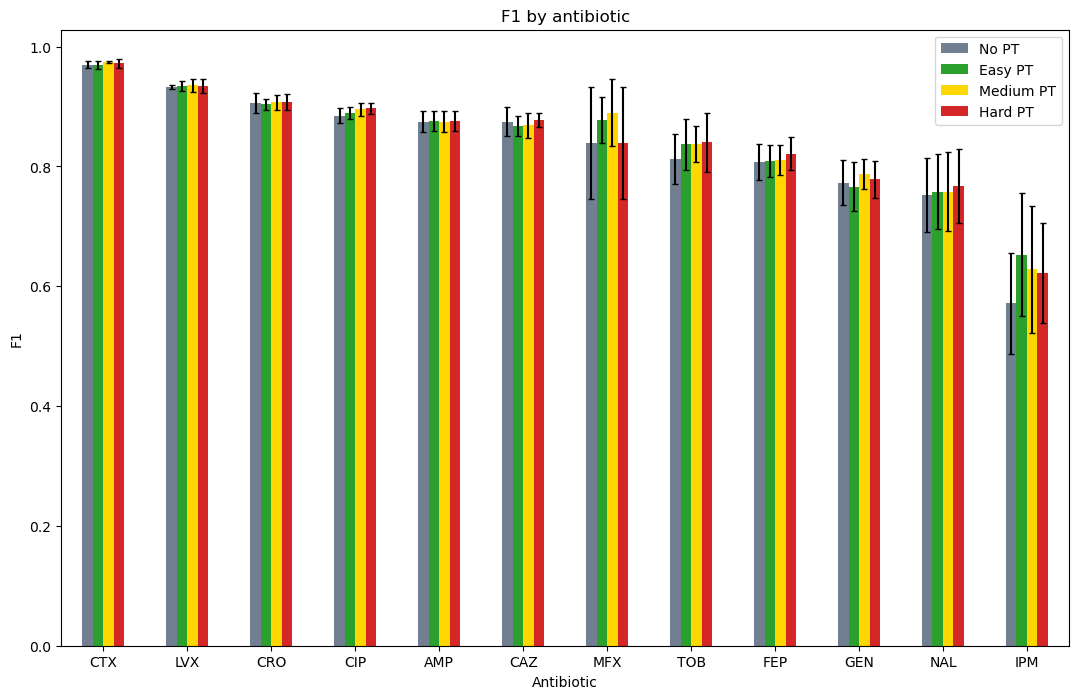

In [11]:
plot_metric_by_ab(df_CV_ab, 'F1')

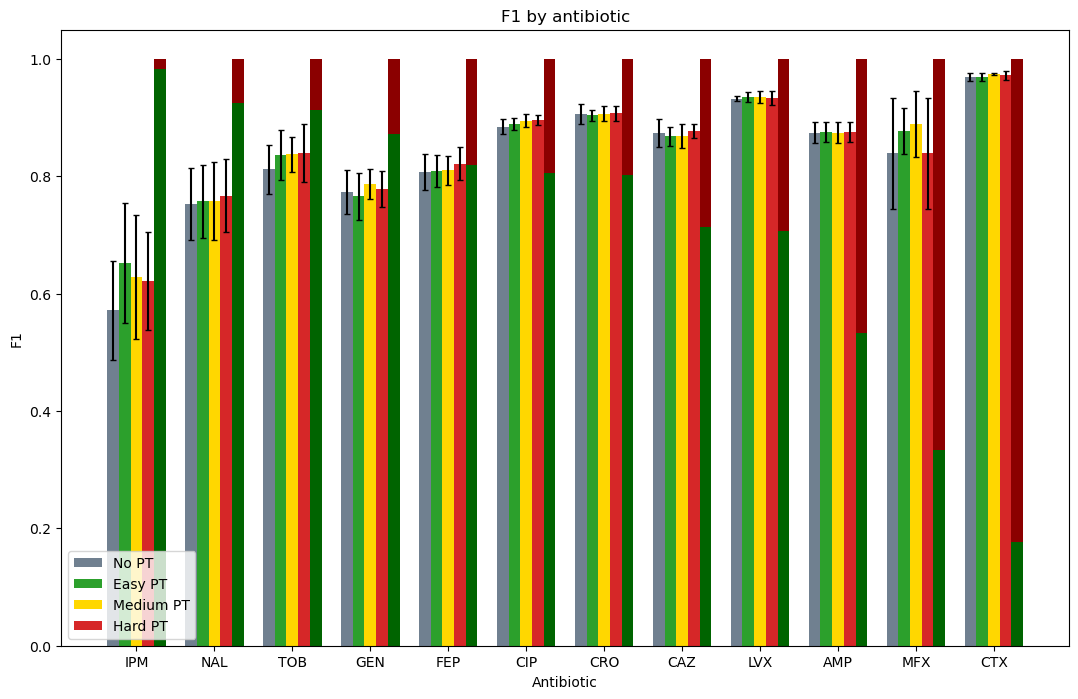

In [12]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False, legend_loc='lower left')

## PT: Random masking | FT: Class masking

In [13]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'))
# results_dict_noPT = torch.load(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'), map_location=torch.device('cpu'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_class', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class', 'CV_results.pkl'))
model_names = ['No PT', 'Easy PT', 'Medium PT', 'Hard PT']
colors = ['slategray', 'tab:green', 'gold', 'tab:red']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [14]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                     std            \
model                No PT   Easy PT Medium PT   Hard PT     No PT   Easy PT   
metric                                                                         
Accuracy          0.947572  0.948383  0.948979  0.949628  0.002161  0.002228   
F1                0.873404  0.874916  0.876475  0.878356  0.004267  0.003956   
Isolate accuracy  0.947572  0.948383  0.948979  0.949628  0.002161  0.002228   
Loss              0.151369  0.148029  0.145753  0.147549  0.008300  0.007169   
Sensitivity       0.836060  0.834348  0.836614  0.840482  0.010292  0.004948   
Specificity       0.978393  0.979842  0.979986  0.979749  0.001231  0.002093   

                                      
model            Medium PT   Hard PT  
metric                                
Accuracy          0.003364  0.002527  
F1                0.007326  0.004650  
Isolate accuracy  0.003364  0.002527  
Loss              0.009863  0.007940  
Sensitivity       0.007298  0.008009  
Specificity       0.002510  0.001941

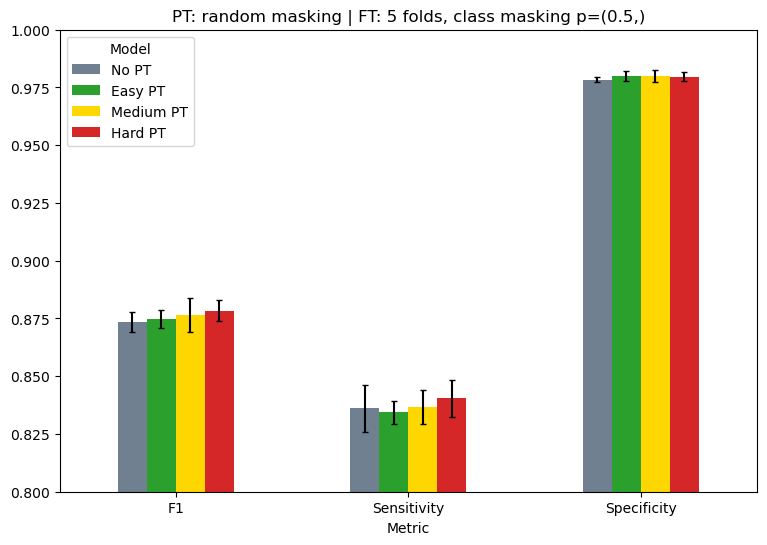

In [15]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: random masking | FT: 5 folds, class masking p=(0.5,)')
plt.show()

### Antibiotic level

In [16]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

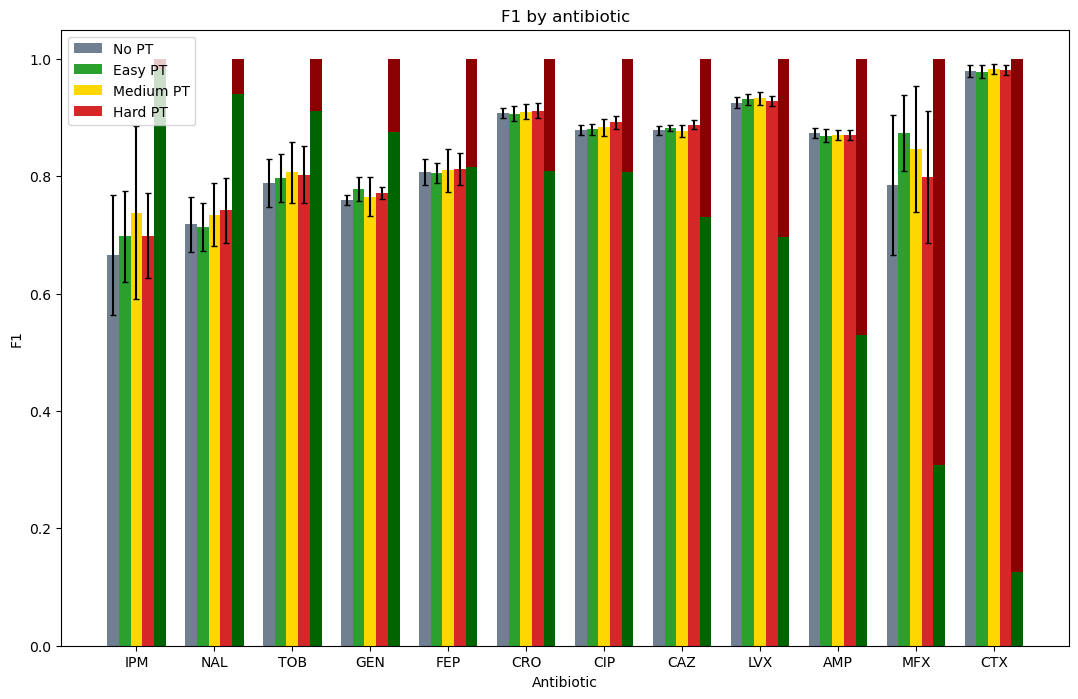

In [17]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False)

## PT: Class masking | FT: Random masking

In [51]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

C:\Users\jespe\AppData\Local\Temp\ipykernel_27420\4062939884.py:2: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)


### Compare metrics

In [52]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_0.9', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_0.9', 'CV_results.pkl'))
model_names = ['No CPT', 'Easy CPT', 'Medium CPT', 'Hard CPT']
colors = ['slategray', 'darkgreen', 'darkgoldenrod', 'darkred']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

In [53]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                      std            \
model               No CPT  Easy CPT Medium CPT  Hard CPT    No CPT  Easy CPT   
metric                                                                          
Accuracy          0.946814  0.947611   0.946503  0.946217  0.004637  0.004291   
F1                0.874695  0.876991   0.873534  0.873309  0.009961  0.008907   
Isolate accuracy  0.946814  0.947611   0.946503  0.767514  0.004637  0.004291   
Loss              0.149597  0.148138   0.147769  0.151231  0.008172  0.009704   
Sensitivity       0.836947  0.841948   0.832904  0.835651  0.012828  0.013077   
Specificity       0.978131  0.977746   0.978890  0.977730  0.002428  0.003376   

                                       
model            Medium CPT  Hard CPT  
metric                                 
Accuracy           0.005164  0.004955  
F1                 0.011227  0.010473  
Isolate accuracy   0.005164  0.015669  
Loss               0.011967  0.011820  
Sensitivity        0.014379  0.014852  
Specificity        0.002658  0.003726

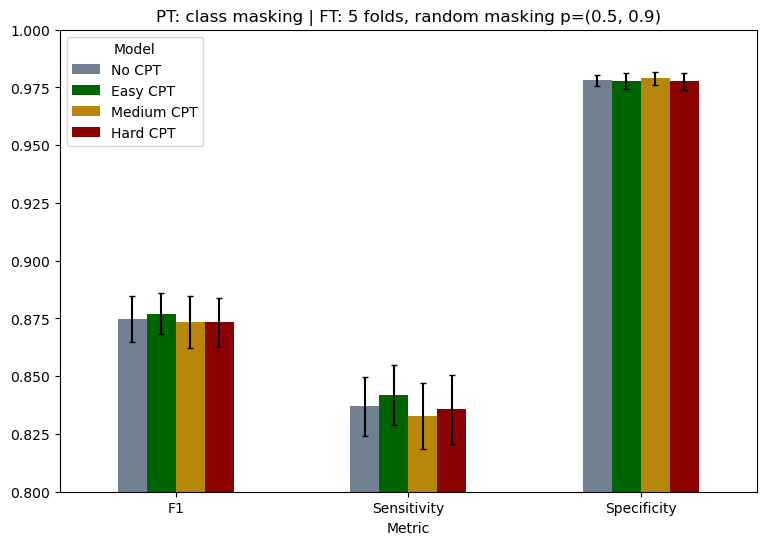

In [54]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: class masking | FT: 5 folds, random masking p=(0.5, 0.9)')
plt.show()

### Antibiotic level

In [55]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

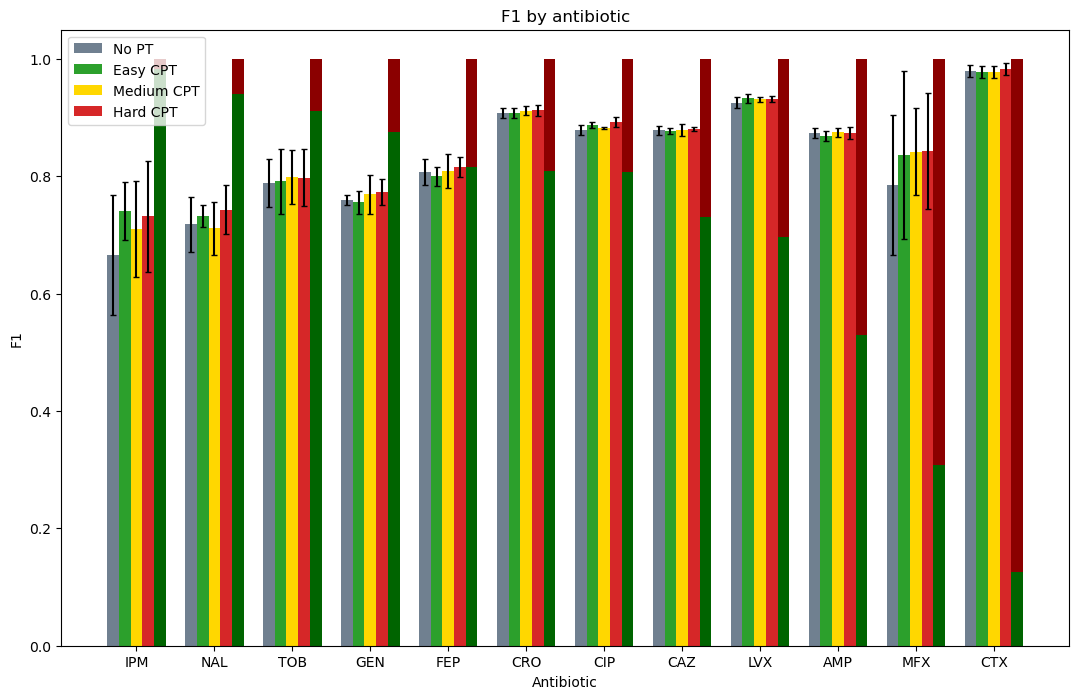

In [85]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False)

## PT: Class masking | FT: Class masking

In [57]:
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_noPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    results_dict_hardPT = CPU_Unpickler(f).load()
# results_dict_noPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'))
# results_dict_easyPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_class', 'CV_results.pkl'))
# results_dict_mediumPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class', 'CV_results.pkl'))
# results_dict_hardPT = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class', 'CV_results.pkl'))
model_names = ['No PT', 'Easy CPT', 'Medium CPT', 'Hard CPT']
colors = ['slategray', 'darkgreen', 'darkgoldenrod', 'darkred']
results_dict_list = [results_dict_noPT, results_dict_easyPT, results_dict_mediumPT, results_dict_hardPT]
results_dict_noPT.keys()

dict_keys(['train_losses', 'losses', 'accs', 'iso_accs', 'sensitivities', 'specificities', 'F1_scores', 'iso_stats', 'ab_stats'])

### Compare metrics

In [58]:
df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_CV

avg                                      std            \
model                No PT  Easy CPT Medium CPT  Hard CPT     No PT  Easy CPT   
metric                                                                          
Accuracy          0.947572  0.947660   0.948753  0.950298  0.002161  0.002662   
F1                0.873404  0.873679   0.876492  0.879477  0.004267  0.004697   
Isolate accuracy  0.947572  0.947660   0.948753  0.950298  0.002161  0.002662   
Loss              0.151369  0.148669   0.147631  0.146856  0.008300  0.008238   
Sensitivity       0.836060  0.836449   0.840490  0.838171  0.010292  0.009150   
Specificity       0.978393  0.978360   0.978635  0.981268  0.001231  0.003971   

                                       
model            Medium CPT  Hard CPT  
metric                                 
Accuracy           0.002788  0.002883  
F1                 0.005696  0.005968  
Isolate accuracy   0.002788  0.002883  
Loss               0.008179  0.006702  
Sensitivity        0.008301  0.011392  
Specificity        0.001701  0.002151

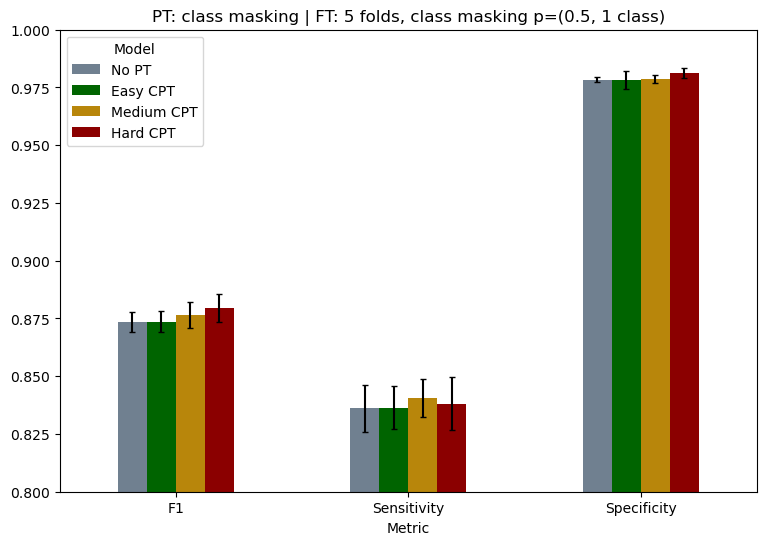

In [59]:
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)
plt.legend(title='Model')
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('PT: class masking | FT: 5 folds, class masking p=(0.5, 1 class)')
plt.show()

### Antibiotic level

In [60]:
df_CV_ab_list = [get_ab_stats_df(results_dict) for results_dict in results_dict_list]
df_CV_ab = pd.concat(df_CV_ab_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_CV_ab = df_CV_ab.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_CV_ab_tmp = df_CV_ab.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_CV_ab_tmp.insert(i, col, df_CV_ab[col].agg('mean', axis=1))
df_CV_ab = df_CV_ab_tmp

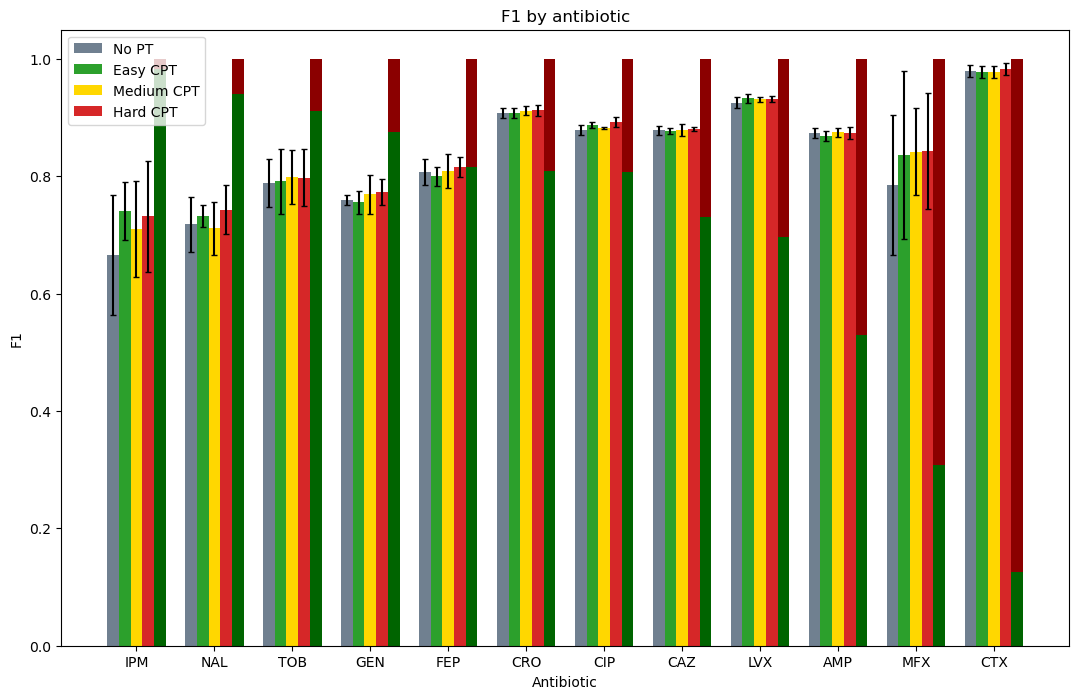

In [61]:
plot_metric_by_ab_with_distr(df_CV_ab, 'F1', show_distr_std=False)

# Compare pre-training masking strategies and difficulties

## FT: Random masking

In [132]:
## No pre-training
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    res_noPT = CPU_Unpickler(f).load()
    
## PT: Random masking
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    res_rnd_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    res_rnd_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    res_rnd_hardPT = CPU_Unpickler(f).load()
    
## PT: Class masking
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    res_class_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    res_class_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_0.9', 'CV_results.pkl'), 'rb') as f:
    res_class_hardPT = CPU_Unpickler(f).load()
    
model_names = ['No PT', 'Easy PT', 'Easy CPT', 'Medium PT', 'Medium CPT', 'Hard PT', 'Hard CPT']
colors = ['slategray', 'forestgreen', 'darkgreen', 'gold', 'darkgoldenrod', 'red', 'darkred']
results_dict_list = [res_noPT, res_rnd_easyPT, res_class_easyPT, res_rnd_mediumPT, res_class_mediumPT, res_rnd_hardPT, res_class_hardPT]

df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_avg = df_CV.drop(('avg', 'No PT'), axis=1).drop('std', axis=1)
for i in range(df_avg.shape[0]):
    df_avg.iloc[i, :] = df_avg.iloc[i, :] - df_CV.loc[:, ('avg', 'No PT')].values[i]
df_avg

avg                                                   
model              Easy PT  Easy CPT Medium PT Medium CPT   Hard PT  Hard CPT
metric                                                                       
Accuracy          0.000177  0.000797  0.001635  -0.000311  0.002086 -0.000597
F1                0.000770  0.002296  0.003826  -0.001161  0.005122 -0.001386
Isolate accuracy  0.000177  0.000797  0.001635  -0.000311  0.002086 -0.179300
Loss             -0.000405 -0.001459 -0.003096  -0.001828 -0.001225  0.001634
Sensitivity       0.003032  0.005001  0.003469  -0.004043  0.006153 -0.001296
Specificity      -0.000636 -0.000386  0.001107   0.000758  0.000927 -0.000402

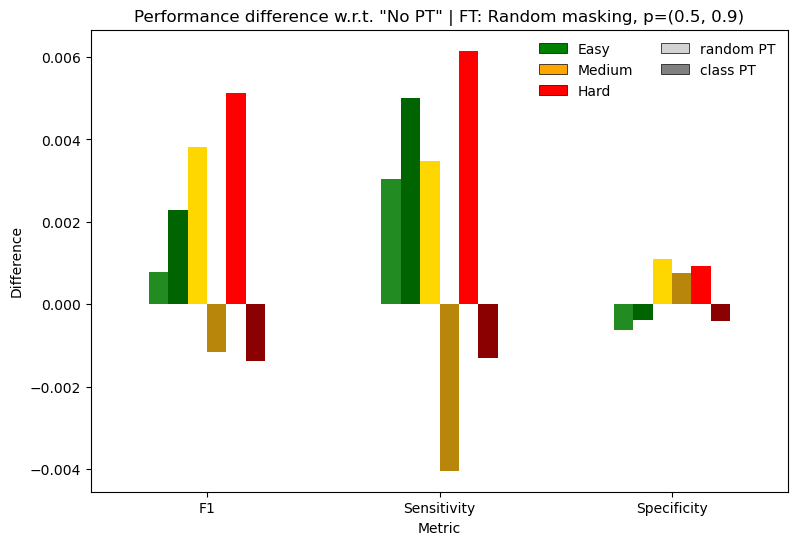

In [133]:
fig, ax = plt.subplots(figsize=(9, 6))
df_avg.drop(drop_metrics).plot(kind='bar', rot=0, figsize=(9, 6), color=colors[1:], ax=ax)
ax.set_title('Performance difference w.r.t. "No PT" | FT: Random masking, p=(0.5, 0.9)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy', 'Medium', 'Hard', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,  
    # loc='lower right',
)

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', 'rndFT_rel_diff.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

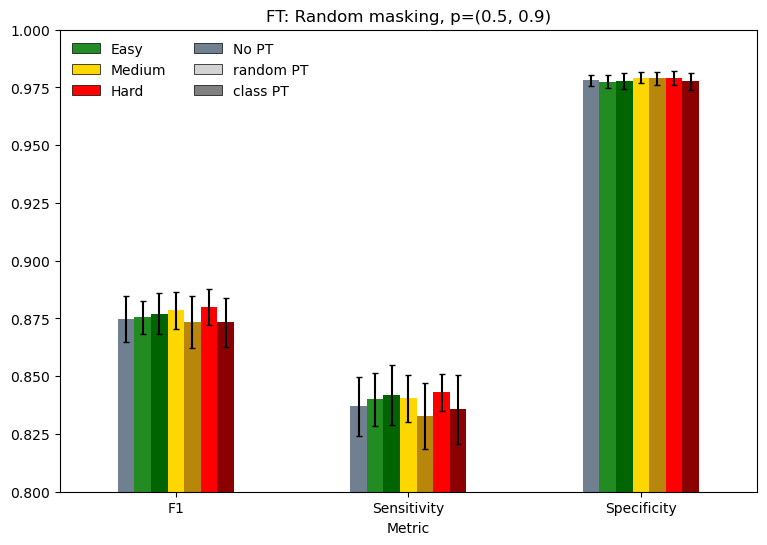

In [134]:
colors = ['slategray', 'forestgreen', 'darkgreen', 'gold', 'darkgoldenrod', 'red', 'darkred']
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('FT: Random masking, p=(0.5, 0.9)')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', 'rndFT_abs_diff.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

## FT: Class masking

In [135]:
## No pre-training
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    res_noPT = CPU_Unpickler(f).load()
    
## PT: Random masking
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    res_rnd_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    res_rnd_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    res_rnd_hardPT = CPU_Unpickler(f).load()
    
## PT: Class masking
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_easyCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    res_class_easyPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    res_class_mediumPT = CPU_Unpickler(f).load()
with open(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class', 'CV_results.pkl'), 'rb') as f:
    res_class_hardPT = CPU_Unpickler(f).load()
    
model_names = ['No PT', 'Easy PT', 'Easy CPT', 'Medium PT', 'Medium CPT', 'Hard PT', 'Hard CPT']
colors = ['tab:gray', 'forestgreen', 'darkgreen', 'gold', 'darkgoldenrod', 'red', 'darkred']
results_dict_list = [res_noPT, res_rnd_easyPT, res_class_easyPT, res_rnd_mediumPT, res_class_mediumPT, res_rnd_hardPT, res_class_hardPT]

df_CV_list = [get_average_and_std_df(results_dict) for results_dict in results_dict_list]
df_CV = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV = df_CV.reindex(columns=model_names, level=1)
df_avg = df_CV.drop(('avg', 'No PT'), axis=1).drop('std', axis=1)
for i in range(df_avg.shape[0]):
    df_avg.iloc[i, :] = df_avg.iloc[i, :] - df_CV.loc[:, ('avg', 'No PT')].values[i]
df_avg

avg                                                   
model              Easy PT  Easy CPT Medium PT Medium CPT   Hard PT  Hard CPT
metric                                                                       
Accuracy          0.000811  0.000088  0.001407   0.001181  0.002056  0.002725
F1                0.001512  0.000275  0.003071   0.003088  0.004952  0.006073
Isolate accuracy  0.000811  0.000088  0.001407   0.001181  0.002056  0.002725
Loss             -0.003340 -0.002700 -0.005616  -0.003738 -0.003820 -0.004513
Sensitivity      -0.001712  0.000388  0.000553   0.004430  0.004422  0.002111
Specificity       0.001449 -0.000033  0.001593   0.000242  0.001356  0.002875

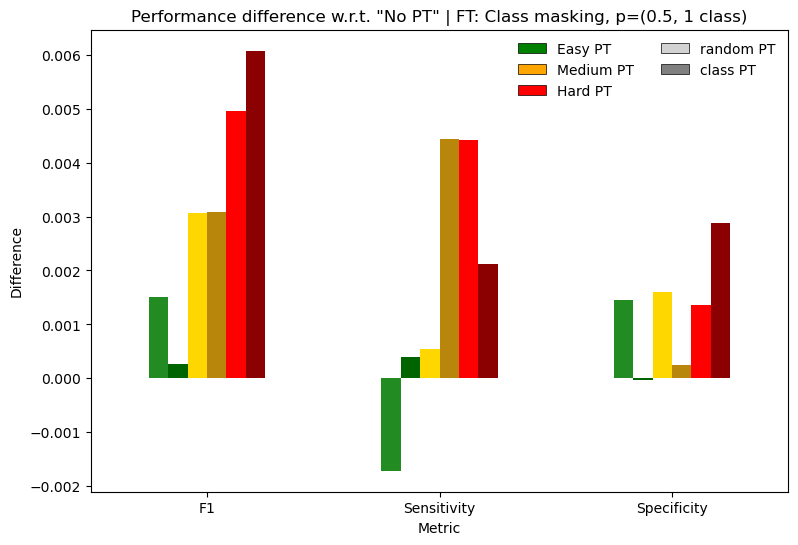

In [136]:
fig, ax = plt.subplots(figsize=(9, 6))
df_avg.drop(drop_metrics).plot(kind='bar', rot=0, figsize=(9, 6), color=colors[1:], ax=ax)
ax.set_title('Performance difference w.r.t. "No PT" | FT: Class masking, p=(0.5, 1 class)')
ax.set_xlabel('Metric')
ax.set_ylabel('Difference')
easy = Rectangle((0,0),1,1,fc='green', edgecolor='k', linewidth=0.5)
medium = Rectangle((0,0),1,1,fc='orange', edgecolor='k', linewidth=0.5)
hard = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax.legend(
    handles=[easy, medium, hard, pt, cpt], 
    labels=['Easy PT', 'Medium PT', 'Hard PT', 'random PT', 'class PT'],
    ncols=2,
    framealpha=0,
    # loc='lower right',
)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', 'classFT_rel_diff.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

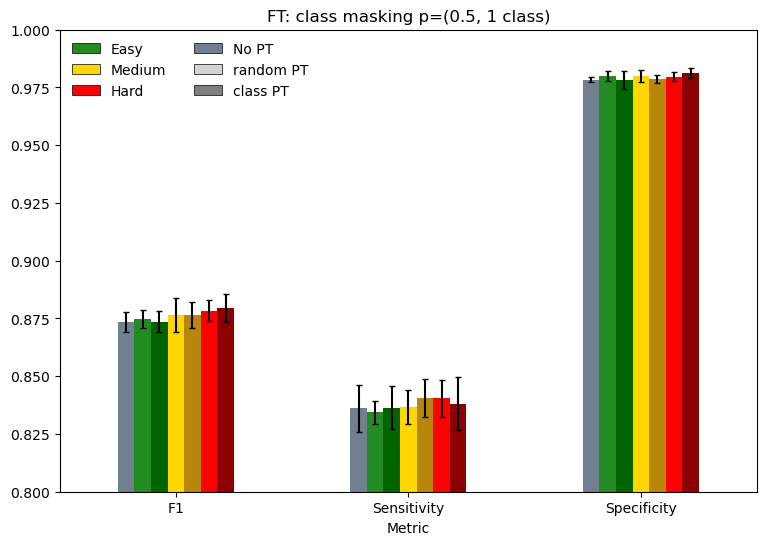

In [137]:
colors = ['slategray', 'forestgreen', 'darkgreen', 'gold', 'darkgoldenrod', 'red', 'darkred']
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, figsize=(9, 6), capsize=2, ecolor='k', color=colors)

noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
pt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
handles = [easyPT, mediumPT, hardPT, noPT, pt, cpt]
labels = ['Easy', 'Medium', 'Hard', 'No PT', 'random PT', 'class PT']

plt.legend(handles, labels, ncols=2, framealpha=0)
plt.ylim(0.8, 1)
plt.xlabel('Metric')
plt.title('FT: class masking p=(0.5, 1 class)')
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', 'classFT_abs_diff.png') 
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

# What happens with decreasing training size?

## Plot metrics against train share

No pre-training

In [382]:
res_noPT_1 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class_val0.99', 'CV_results.pkl'))
res_noPT_5 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class_val0.95', 'CV_results.pkl'))
res_noPT_10 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class_val0.9', 'CV_results.pkl'))
res_noPT_20 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class_val0.8', 'CV_results.pkl'))
res_noPT_30 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.5_class_val0.7', 'CV_results.pkl'))
model_names = ['No PT 1%', 'No PT 5%', 'No PT 10%', 'No PT 20%', 'No PT 30%']
res_dict_list_noPT = [res_noPT_1, res_noPT_5, res_noPT_10, res_noPT_20, res_noPT_30]
df_CV_list = [get_average_and_std_df(res_dict) for res_dict in res_dict_list_noPT]
df_CV_noPT = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV_noPT = df_CV_noPT.reindex(columns=model_names, level=1)

Medium difficulty pre-training

In [383]:
## Random pre-training
res_mediumPT_1 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class_val0.99', 'CV_results.pkl'))
res_mediumPT_5 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class_val0.95', 'CV_results.pkl'))
res_mediumPT_10 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class_val0.9', 'CV_results.pkl'))
res_mediumPT_20 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class_val0.8', 'CV_results.pkl'))
res_mediumPT_30 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumPT_0.5_class_val0.7', 'CV_results.pkl'))
model_names = ['Medium PT 1%', 'Medium PT 5%', 'Medium PT 10%', 'Medium PT 20%', 'Medium PT 30%']
res_dict_list_mediumPT = [res_mediumPT_1, res_mediumPT_5, res_mediumPT_10, res_mediumPT_20, res_mediumPT_30]
df_CV_list = [get_average_and_std_df(res_dict) for res_dict in res_dict_list_mediumPT]
df_CV_mediumPT = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV_mediumPT = df_CV_mediumPT.reindex(columns=model_names, level=1)

## Class pre-training
res_mediumCPT_1 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class_val0.99', 'CV_results.pkl'))
res_mediumCPT_5 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class_val0.95', 'CV_results.pkl'))
res_mediumCPT_10 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class_val0.9', 'CV_results.pkl'))
res_mediumCPT_20 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class_val0.8', 'CV_results.pkl'))
res_mediumCPT_30 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_mediumCPT_0.5_class_val0.7', 'CV_results.pkl'))
model_names = ['Medium CPT 1%', 'Medium CPT 5%', 'Medium CPT 10%', 'Medium CPT 20%', 'Medium CPT 30%']
res_dict_list_mediumCPT = [res_mediumCPT_1, res_mediumCPT_5, res_mediumCPT_10, res_mediumCPT_20, res_mediumCPT_30]
df_CV_list = [get_average_and_std_df(res_dict) for res_dict in res_dict_list_mediumCPT]
df_CV_mediumCPT = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV_mediumCPT = df_CV_mediumCPT.reindex(columns=model_names, level=1)

Hard difficulty pre-training

In [384]:
## Random pre-training
res_hardPT_1 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class_val0.99', 'CV_results.pkl'))
res_hardPT_5 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class_val0.95', 'CV_results.pkl'))
res_hardPT_10 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class_val0.9', 'CV_results.pkl'))
res_hardPT_20 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class_val0.8', 'CV_results.pkl'))
res_hardPT_30 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.5_class_val0.7', 'CV_results.pkl'))
model_names = ['Hard PT 1%', 'Hard PT 5%', 'Hard PT 10%', 'Hard PT 20%', 'Hard PT 30%']
res_dict_list_hardPT = [res_hardPT_1, res_hardPT_5, res_hardPT_10, res_hardPT_20, res_hardPT_30]
df_CV_list = [get_average_and_std_df(res_dict) for res_dict in res_dict_list_hardPT]
df_CV_hardPT = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV_hardPT = df_CV_hardPT.reindex(columns=model_names, level=1)

## Class pre-training
res_hardCPT_1 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class_val0.99', 'CV_results.pkl'))
res_hardCPT_5 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class_val0.95', 'CV_results.pkl'))
res_hardCPT_10 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class_val0.9', 'CV_results.pkl'))
res_hardCPT_20 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class_val0.8', 'CV_results.pkl'))
res_hardCPT_30 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.5_class_val0.7', 'CV_results.pkl'))
model_names = ['Hard CPT 1%', 'Hard COT 5%', 'Hard CPT 10%', 'Hard CPT 20%', 'Hard CPT 30%']
res_dict_list_hardCPT = [res_hardCPT_1, res_hardCPT_5, res_hardCPT_10, res_hardCPT_20, res_hardCPT_30]
df_CV_list = [get_average_and_std_df(res_dict) for res_dict in res_dict_list_hardCPT]
df_CV_hardCPT = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV_hardCPT = df_CV_hardCPT.reindex(columns=model_names, level=1)

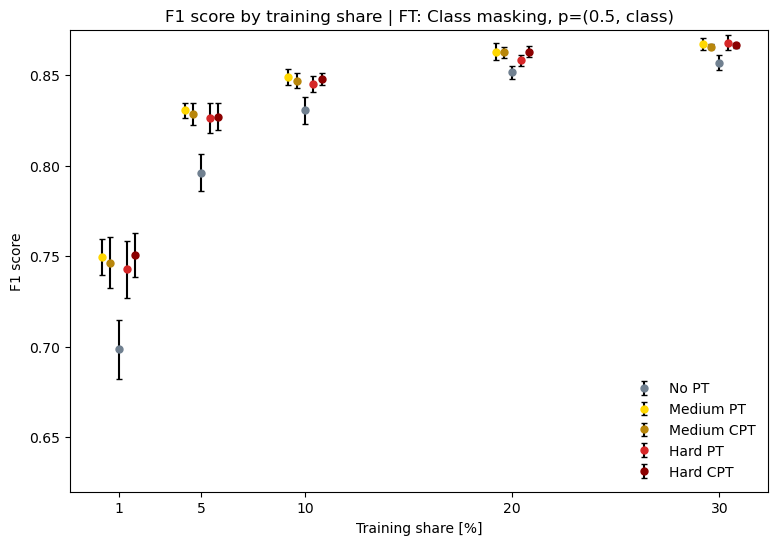

In [385]:
train_shares = [1, 5, 10, 20, 30] # in percent
_, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(train_shares, df_CV_noPT.loc['F1', 'avg'], yerr=df_CV_noPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumPT.loc['F1', 'avg'], yerr=df_CV_mediumPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_mediumCPT.loc['F1', 'avg'], yerr=df_CV_mediumCPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_hardPT.loc['F1', 'avg'], yerr=df_CV_hardPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_hardCPT.loc['F1', 'avg'], yerr=df_CV_hardCPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('F1 score by training share | FT: Class masking, p=(0.5, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('F1 score')
ax.set_xticks(train_shares)
ax.legend(framealpha=0, loc='lower right')
plt.ylim(0.62, 0.875)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', '0.5classFT_F1_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

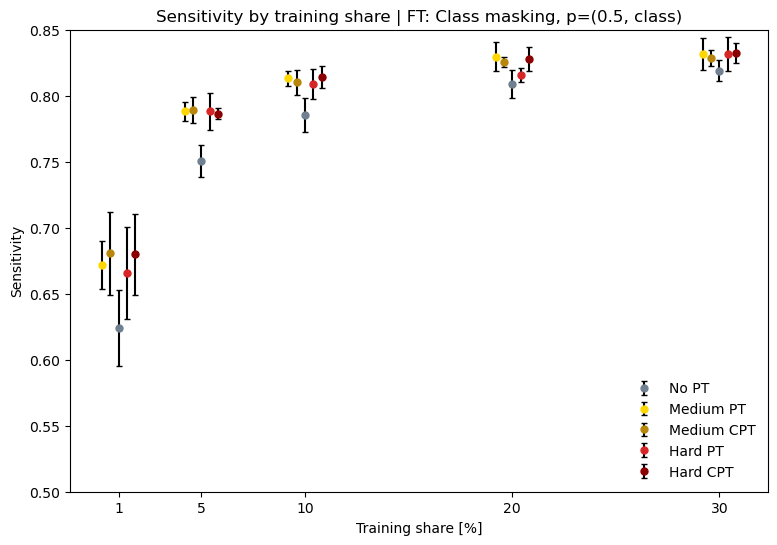

In [386]:
_, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(train_shares, df_CV_noPT.loc['Sensitivity', 'avg'], yerr=df_CV_noPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumPT.loc['Sensitivity', 'avg'], yerr=df_CV_mediumPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_mediumCPT.loc['Sensitivity', 'avg'], yerr=df_CV_mediumCPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_hardPT.loc['Sensitivity', 'avg'], yerr=df_CV_hardPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_hardCPT.loc['Sensitivity', 'avg'], yerr=df_CV_hardCPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Sensitivity by training share | FT: Class masking, p=(0.5, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Sensitivity')
ax.set_xticks(train_shares)
ax.legend(framealpha=0, loc='lower right')
plt.ylim(0.5, 0.85)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', '0.5classFT_sens_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

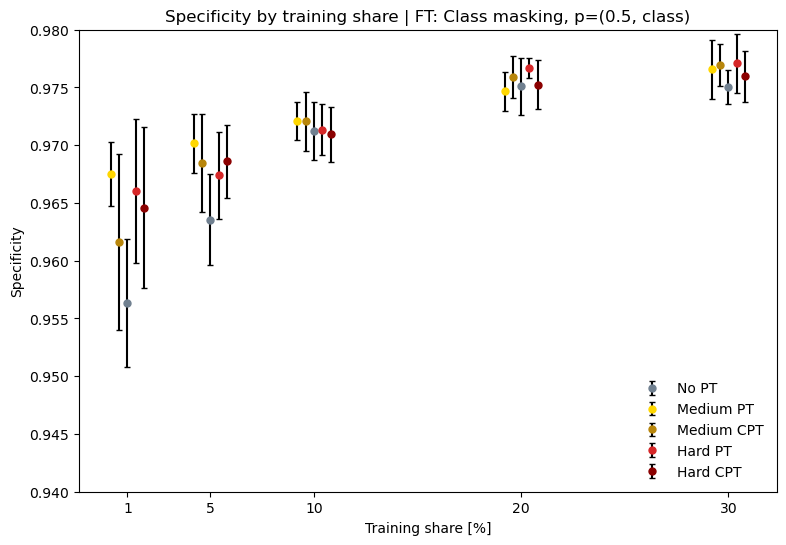

In [387]:
_, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(train_shares, df_CV_noPT.loc['Specificity', 'avg'], yerr=df_CV_noPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumPT.loc['Specificity', 'avg'], yerr=df_CV_mediumPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_mediumCPT.loc['Specificity', 'avg'], yerr=df_CV_mediumCPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_hardPT.loc['Specificity', 'avg'], yerr=df_CV_hardPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_hardCPT.loc['Specificity', 'avg'], yerr=df_CV_hardCPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Specificity by training share | FT: Class masking, p=(0.5, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Specificity')
ax.set_xticks(train_shares)
ax.legend(framealpha=0, loc='lower right')
plt.ylim(0.94, 0.980)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', '0.5classFT_spec_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

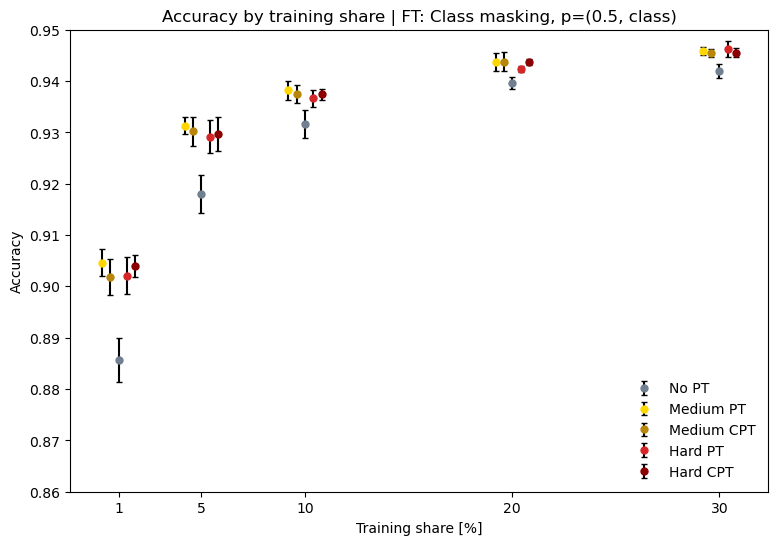

In [388]:
_, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(train_shares, df_CV_noPT.loc['Accuracy', 'avg'], yerr=df_CV_noPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s-0.8 for s in train_shares], df_CV_mediumPT.loc['Accuracy', 'avg'], yerr=df_CV_mediumPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='gold', label='Medium PT', markersize=5)
ax.errorbar([s-0.4 for s in train_shares], df_CV_mediumCPT.loc['Accuracy', 'avg'], yerr=df_CV_mediumCPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkgoldenrod', label='Medium CPT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_hardPT.loc['Accuracy', 'avg'], yerr=df_CV_hardPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
ax.errorbar([s+0.8 for s in train_shares], df_CV_hardCPT.loc['Accuracy', 'avg'], yerr=df_CV_hardCPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Accuracy by training share | FT: Class masking, p=(0.5, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Accuracy')
ax.set_xticks(train_shares)
ax.legend(framealpha=0, loc='lower right')
plt.ylim(0.86, 0.95)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', '0.5classFT_acc_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

## What happens at the antibiotic level?

### No pre-training

In [389]:
df_ab_noPT_list = [get_ab_stats_df(res_dict) for res_dict in res_dict_list_noPT]
model_names = ['No PT 1%', 'No PT 5%', 'No PT 10%', 'No PT 20%', 'No PT 30%']
df_ab_noPT = pd.concat(df_ab_noPT_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_ab_noPT = df_ab_noPT.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_ab_noPT_tmp = df_ab_noPT.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_ab_noPT_tmp.insert(i, col, df_ab_noPT[col].agg('mean', axis=1))
df_ab_noPT = df_ab_noPT_tmp
df_ab_noPT[['sensitivity_avg', 'sensitivity_std']]

C:\Users\jespe\AppData\Local\Temp\ipykernel_27420\2128198428.py:60: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(arr, axis=0)
c:\Users\jespe\miniconda3\envs\ARFusion\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


sensitivity_avg                                          \
model             No PT 1%  No PT 5% No PT 10% No PT 20% No PT 30%   
antibiotic                                                           
AMP               0.718458  0.795110  0.784337  0.819771  0.828751   
CAZ               0.674359  0.794132  0.807629  0.815143  0.827146   
CIP               0.710112  0.812837  0.828125  0.825091  0.835976   
CRO               0.557629  0.772798  0.818431  0.839151  0.854171   
CTX               0.956156  0.979959  0.968031  0.972462  0.975843   
FEP               0.467421  0.700510  0.738133  0.765311  0.774262   
GEN               0.016225  0.285180  0.527577  0.604676  0.603940   
IPM               0.000000  0.011765  0.010811  0.147706  0.237345   
LVX               0.796513  0.888304  0.907645  0.906868  0.909445   
MFX               0.800000  0.947052  0.926595  0.932047  0.909266   
NAL               0.485879  0.477732  0.520572  0.558558  0.589372   
TOB               0.283665  0.478528  0.660936  0.715513  0.733770   

           sensitivity_std                                          
model             No PT 1%  No PT 5% No PT 10% No PT 20% No PT 30%  
antibiotic                                                          
AMP               0.061937  0.016048  0.009475  0.010305  0.010794  
CAZ               0.041950  0.024688  0.051041  0.031844  0.019108  
CIP               0.073796  0.026069  0.010575  0.024615  0.017705  
CRO               0.121760  0.019868  0.019924  0.016603  0.009471  
CTX               0.041522  0.010247  0.014575  0.009491  0.009648  
FEP               0.257591  0.084428  0.034416  0.040079  0.024827  
GEN               0.020321  0.151383  0.101938  0.038031  0.064504  
IPM               0.000000  0.023529  0.021622  0.127686  0.102678  
LVX               0.092364  0.019824  0.010980  0.012034  0.012453  
MFX               0.400000  0.067378  0.077826  0.083892  0.054461  
NAL               0.097420  0.151972  0.069554  0.013000  0.073186  
TOB               0.209340  0.142098  0.069222  0.035451  0.010500

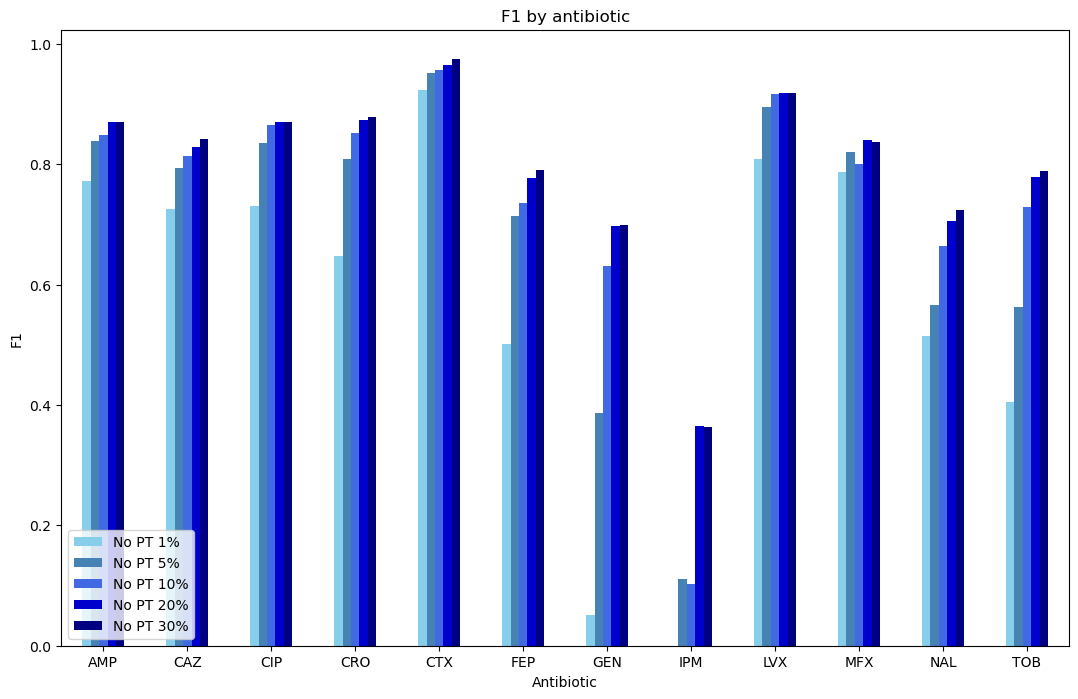

In [390]:
plot_metric_by_ab(df_ab_noPT, 'F1', legend_loc='lower left', use_std=False, sort_by_desc_metric=False, 
                             colors=['skyblue', 'steelblue', 'royalblue', 'mediumblue', 'navy'])

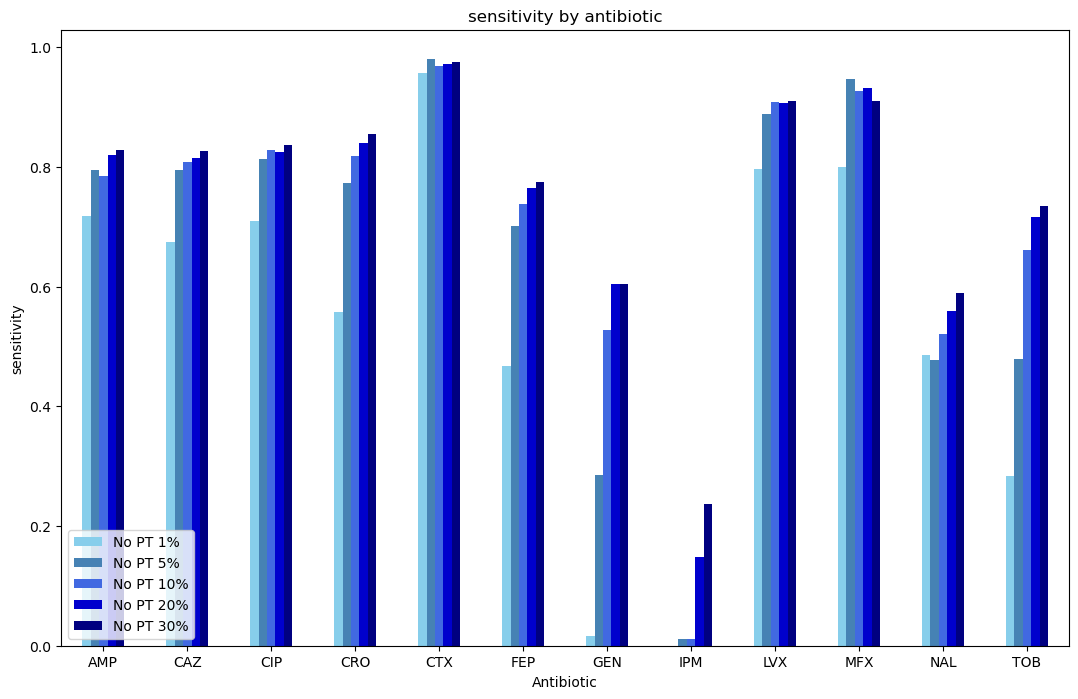

In [391]:
plot_metric_by_ab(df_ab_noPT, 'sensitivity', legend_loc='lower left', use_std=False, sort_by_desc_metric=False, 
                             colors=['skyblue', 'steelblue', 'royalblue', 'mediumblue', 'navy'])

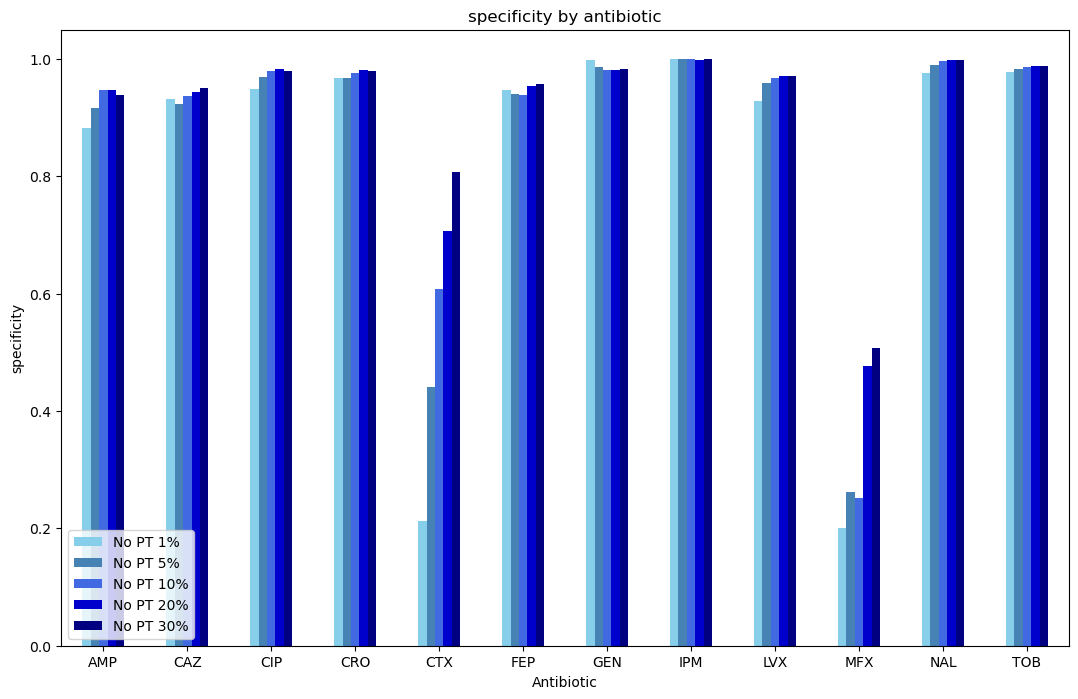

In [392]:
plot_metric_by_ab(df_ab_noPT, 'specificity', legend_loc='lower left', use_std=False, sort_by_desc_metric=False, 
                             colors=['skyblue', 'steelblue', 'royalblue', 'mediumblue', 'navy'])

### Hard class pre-training

In [393]:
df_ab_hardCPT_list = [get_ab_stats_df(res_dict) for res_dict in res_dict_list_hardCPT]
model_names = ['Hard CPT 1%', 'Hard CPT 5%', 'Hard CPT 10%', 'Hard CPT 20%', 'Hard CPT 30%']
df_ab_hardCPT = pd.concat(df_ab_hardCPT_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('antibiotic', append=True).unstack(level=0)
df_ab_hardCPT = df_ab_hardCPT.reindex(columns=model_names, level=1)
reduce_cols = ['avg_num', 'std_num', 'S_share_median', 'R_share_median', 'S_share_std', 'R_share_std']
df_ab_hardCPT_tmp = df_ab_hardCPT.drop(reduce_cols, axis=1)
for i, col in enumerate(reduce_cols):
    df_ab_hardCPT_tmp.insert(i, col, df_ab_hardCPT[col].agg('mean', axis=1))
df_ab_hardCPT = df_ab_hardCPT_tmp
df_ab_hardCPT[['sensitivity_avg', 'sensitivity_std']]

sensitivity_avg                                                     \
model          Hard CPT 1% Hard CPT 5% Hard CPT 10% Hard CPT 20% Hard CPT 30%   
antibiotic                                                                      
AMP               0.718782    0.817349     0.806790     0.816785     0.820000   
CAZ               0.752684    0.811491     0.844262     0.840828     0.835819   
CIP               0.755681    0.813297     0.848238     0.863455     0.866376   
CRO               0.633880    0.760626     0.828693     0.847058     0.857625   
CTX               0.969847    0.980025     0.973588     0.973585     0.978055   
FEP               0.600899    0.731193     0.771642     0.792032     0.779891   
GEN               0.181022    0.518314     0.618366     0.651235     0.673833   
IPM               0.045904    0.165990     0.280402     0.434209     0.542888   
LVX               0.883138    0.905117     0.912746     0.923767     0.920714   
MFX               0.844444    0.966407     0.938895     0.951402     0.915559   
NAL               0.358110    0.466718     0.551453     0.603594     0.647559   
TOB               0.401003    0.729602     0.747151     0.751609     0.756619   

           sensitivity_std                                                     
model          Hard CPT 1% Hard CPT 5% Hard CPT 10% Hard CPT 20% Hard CPT 30%  
antibiotic                                                                     
AMP               0.058312    0.009973     0.009952     0.010990     0.009567  
CAZ               0.061276    0.036196     0.043436     0.024063     0.030112  
CIP               0.046999    0.018645     0.013531     0.012889     0.019865  
CRO               0.058438    0.047345     0.023435     0.016069     0.010281  
CTX               0.028285    0.006748     0.010200     0.008243     0.007631  
FEP               0.142125    0.082093     0.038381     0.022010     0.024776  
GEN               0.064154    0.057774     0.034195     0.019663     0.039408  
IPM               0.080171    0.100001     0.077819     0.056542     0.098269  
LVX               0.048805    0.015123     0.019461     0.005522     0.015135  
MFX               0.257361    0.037790     0.041949     0.049253     0.037428  
NAL               0.159486    0.167978     0.086954     0.028631     0.074084  
TOB               0.233204    0.018735     0.040748     0.056444     0.035480

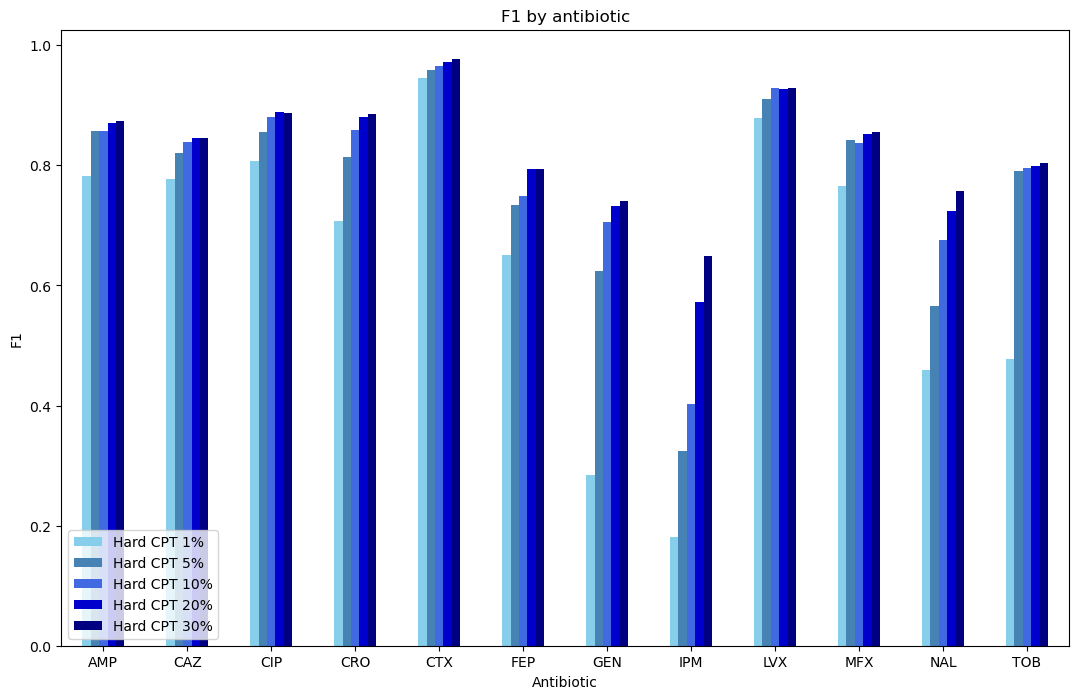

In [394]:
plot_metric_by_ab(df_ab_hardCPT, 'F1', legend_loc='lower left', use_std=False, sort_by_desc_metric=False, 
                             colors=['skyblue', 'steelblue', 'royalblue', 'mediumblue', 'navy'])

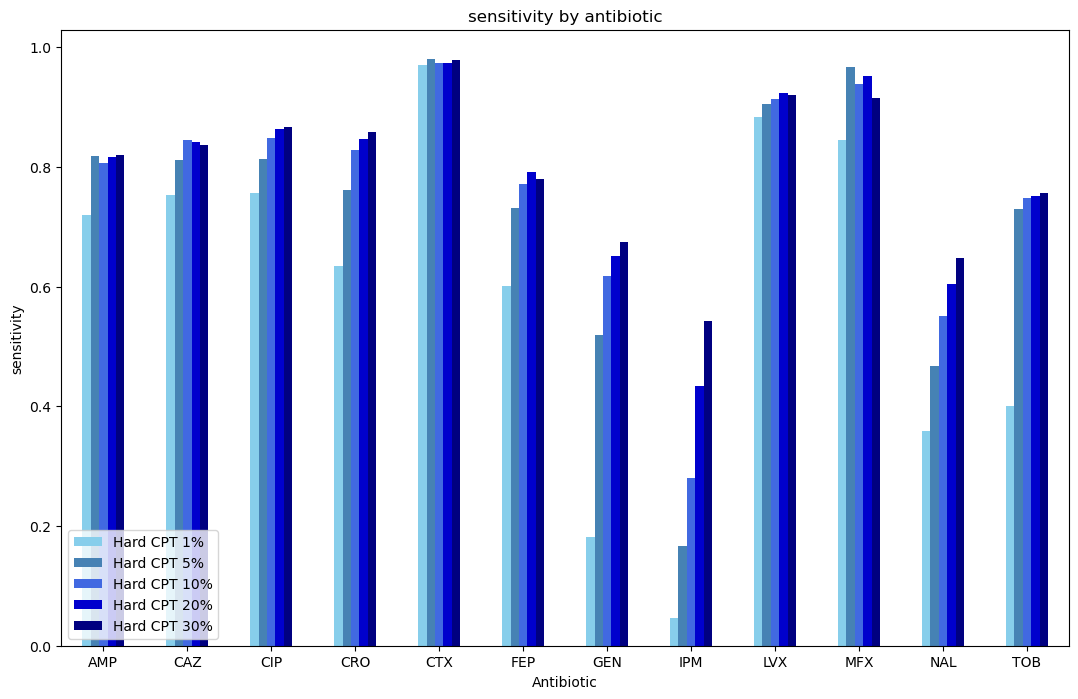

In [395]:
plot_metric_by_ab(df_ab_hardCPT, 'sensitivity', legend_loc='lower left', use_std=False, sort_by_desc_metric=False, 
                             colors=['skyblue', 'steelblue', 'royalblue', 'mediumblue', 'navy'])

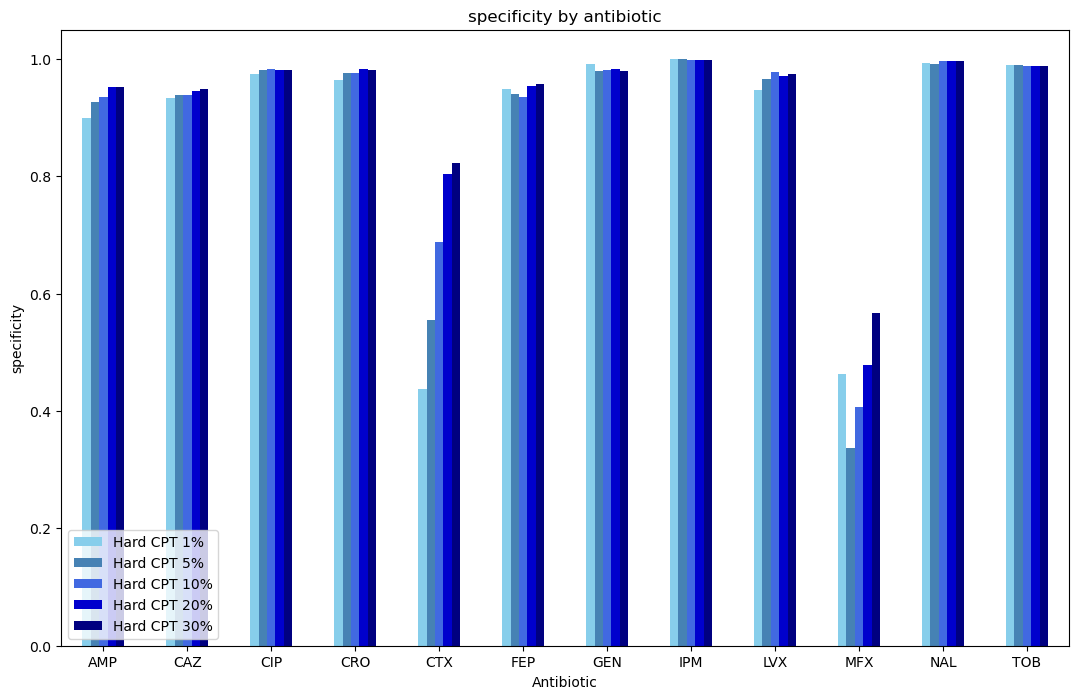

In [396]:
plot_metric_by_ab(df_ab_hardCPT, 'specificity', legend_loc='lower left', use_std=False, sort_by_desc_metric=False, 
                             colors=['skyblue', 'steelblue', 'royalblue', 'mediumblue', 'navy'])

## Harder task | p = (0.75, class)

No pre-training

In [397]:
res_noPT_1 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class_val0.99', 'CV_results.pkl'))
res_noPT_5 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class_val0.95', 'CV_results.pkl'))
res_noPT_10 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class_val0.9', 'CV_results.pkl'))
res_noPT_20 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class_val0.8', 'CV_results.pkl'))
res_noPT_30 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_noPT_0.75_class_val0.7', 'CV_results.pkl'))
model_names = ['No PT 1%', 'No PT 5%', 'No PT 10%', 'No PT 20%', 'No PT 30%']
res_dict_list_noPT = [res_noPT_1, res_noPT_5, res_noPT_10, res_noPT_20, res_noPT_30]
df_CV_list = [get_average_and_std_df(res_dict) for res_dict in res_dict_list_noPT]
df_CV_noPT = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV_noPT = df_CV_noPT.reindex(columns=model_names, level=1)

Hard pre-training

In [398]:
## Random pre-training
res_hardPT_1 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.75_class_val0.99', 'CV_results.pkl'))
res_hardPT_5 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.75_class_val0.95', 'CV_results.pkl'))
res_hardPT_10 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.75_class_val0.9', 'CV_results.pkl'))
res_hardPT_20 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.75_class_val0.8', 'CV_results.pkl'))
res_hardPT_30 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardPT_0.75_class_val0.7', 'CV_results.pkl'))
model_names = ['No PT 1%', 'No PT 5%', 'No PT 10%', 'No PT 20%', 'No PT 30%']
res_dict_list_hardPT = [res_hardPT_1, res_hardPT_5, res_hardPT_10, res_hardPT_20, res_hardPT_30]
df_CV_list = [get_average_and_std_df(res_dict) for res_dict in res_dict_list_hardPT]
df_CV_hardPT = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
df_CV_hardPT = df_CV_hardPT.reindex(columns=model_names, level=1)

## Class pre-training
# res_hardCPT_1 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.75_class_val0.99', 'CV_results.pkl'))
# res_hardCPT_5 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.75_class_val0.95', 'CV_results.pkl'))
# res_hardCPT_10 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.75_class_val0.9', 'CV_results.pkl'))
# res_hardCPT_20 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.75_class_val0.8', 'CV_results.pkl'))
# res_hardCPT_30 = pd.read_pickle(os.path.join(BASE_DIR, 'results', 'MM', 'FT_hardCPT_0.75_class_val0.7', 'CV_results.pkl'))
# model_names = ['No PT 1%', 'No PT 5%', 'No PT 10%', 'No PT 20%', 'No PT 30%']
# res_dict_list_hardCPT = [res_hardCPT_1, res_hardCPT_5, res_hardCPT_10, res_hardCPT_20, res_hardCPT_30]
# df_CV_list = [get_average_and_std_df(res_dict) for res_dict in res_dict_list_hardCPT]
# df_CV_hardCPT = pd.concat(df_CV_list, keys=model_names, names=['model']).reset_index(level=1, drop=True).set_index('metric', append=True).unstack(level=0)
# df_CV_hardCPT = df_CV_hardCPT.reindex(columns=model_names, level=1)

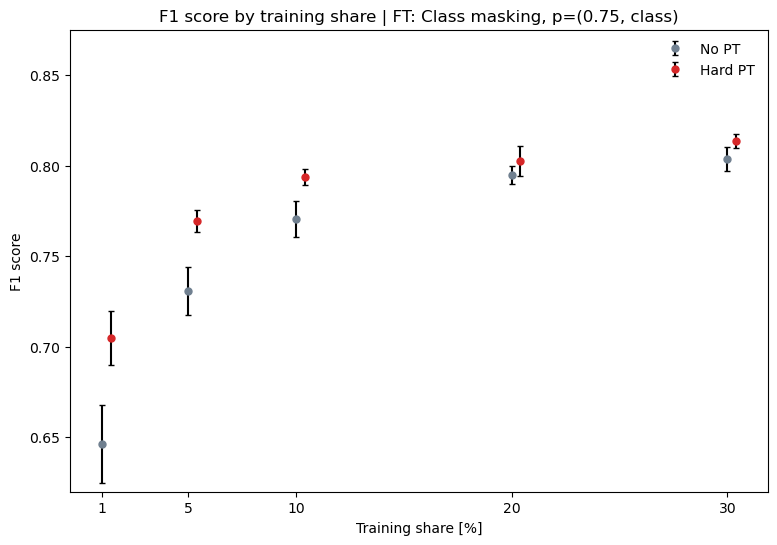

In [399]:
train_shares = [1, 5, 10, 20, 30] # in percent
_, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(train_shares, df_CV_noPT.loc['F1', 'avg'], yerr=df_CV_noPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_hardPT.loc['F1', 'avg'], yerr=df_CV_hardPT.loc['F1', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
# ax.errorbar([s-0.4 for s in train_shares], df_CV_hardCPT.loc['F1', 'avg'], yerr=df_CV_hardCPT.loc['F1', 'std'],
            # fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('F1 score by training share | FT: Class masking, p=(0.75, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('F1 score')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
plt.ylim(0.62, 0.875)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', '0.75classFT_F1_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

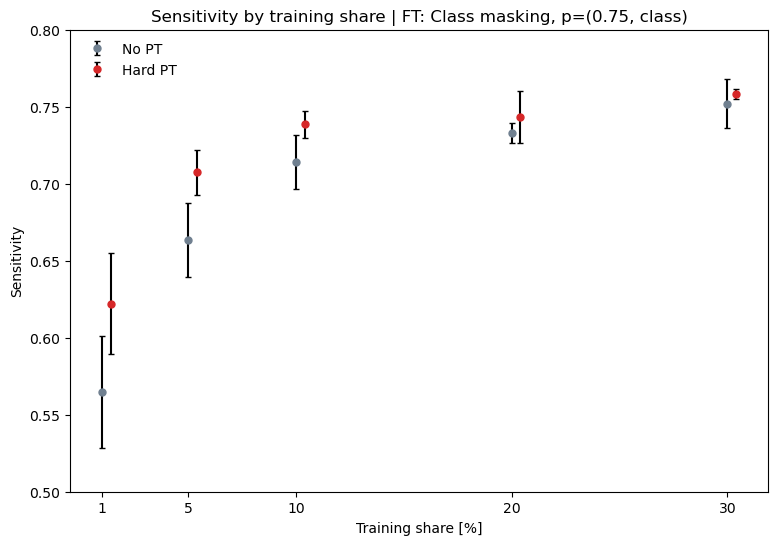

In [400]:
train_shares = [1, 5, 10, 20, 30] # in percent
_, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(train_shares, df_CV_noPT.loc['Sensitivity', 'avg'], yerr=df_CV_noPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_hardPT.loc['Sensitivity', 'avg'], yerr=df_CV_hardPT.loc['Sensitivity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
# ax.errorbar([s-0.4 for s in train_shares], df_CV_hardCPT.loc['Sensitivity', 'avg'], yerr=df_CV_hardCPT.loc['Sensitivity', 'std'],
            # fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Sensitivity by training share | FT: Class masking, p=(0.75, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Sensitivity')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
plt.ylim(0.5, 0.8)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', '0.75classFT_sens_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

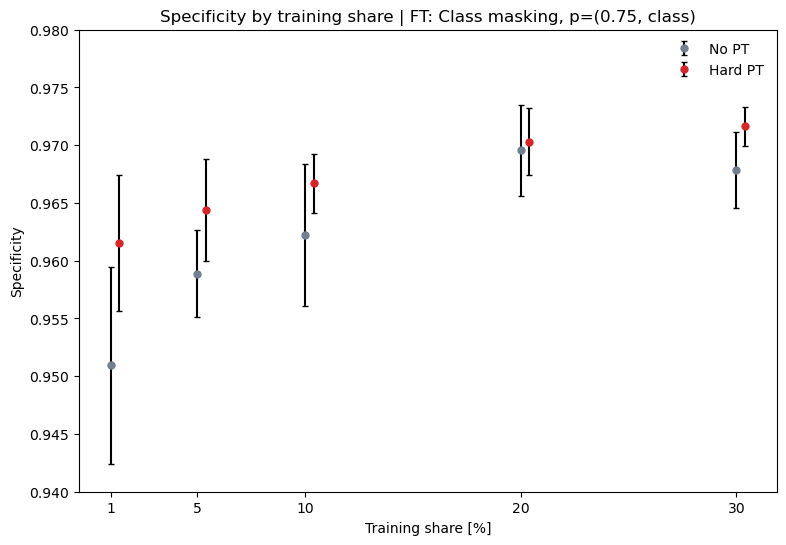

In [401]:
train_shares = [1, 5, 10, 20, 30] # in percent
_, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(train_shares, df_CV_noPT.loc['Specificity', 'avg'], yerr=df_CV_noPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_hardPT.loc['Specificity', 'avg'], yerr=df_CV_hardPT.loc['Specificity', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
# ax.errorbar([s-0.4 for s in train_shares], df_CV_hardCPT.loc['Specificity', 'avg'], yerr=df_CV_hardCPT.loc['Specificity', 'std'],
            # fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Specificity by training share | FT: Class masking, p=(0.75, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Specificity')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
plt.ylim(0.94, 0.980)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', '0.75classFT_spec_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()

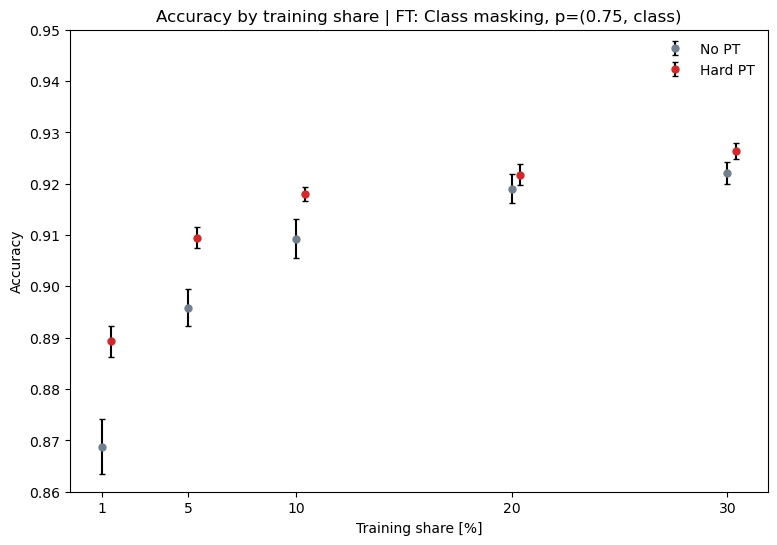

In [402]:
train_shares = [1, 5, 10, 20, 30] # in percent
_, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(train_shares, df_CV_noPT.loc['Accuracy', 'avg'], yerr=df_CV_noPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='slategray', label='No PT', markersize=5)
ax.errorbar([s+0.4 for s in train_shares], df_CV_hardPT.loc['Accuracy', 'avg'], yerr=df_CV_hardPT.loc['Accuracy', 'std'],
            fmt='o', capsize=2, ecolor='k', color='tab:red', label='Hard PT', markersize=5)
# ax.errorbar([s-0.4 for s in train_shares], df_CV_hardCPT.loc['Accuracy', 'avg'], yerr=df_CV_hardCPT.loc['Accuracy', 'std'],
            # fmt='o', capsize=2, ecolor='k', color='darkred', label='Hard CPT', markersize=5)
ax.set_title('Accuracy by training share | FT: Class masking, p=(0.75, class)')
ax.set_xlabel('Training share [%]')
ax.set_ylabel('Accuracy')
ax.set_xticks(train_shares)
ax.legend(framealpha=0)
plt.ylim(0.86, 0.95)
savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_21', '0.75classFT_acc_vs_t-share.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True)
plt.show()